# BERTweet with Interweaving Fine-Tuned Approach on Disability and Gender

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.1 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.2 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [7]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [8]:
MAX_SEQUENCE_LENGTH = 128

In [12]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [10]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Gender

In [13]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Gender
gender_train_df, gender_val_df, gender_test_df = load_data('gender')
X_gender_train, y_gender_train, X_gender_test, y_gender_test, X_gender_val, y_gender_val = load_data_as_arr(gender_train_df, gender_val_df, gender_test_df)

In [14]:
X_disability_train[1]

' mental disability is extremely physical'

In [15]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [16]:
len(X_disability_train)

24904

In [17]:
X_gender_train[0]

' sexual harassment in the workplace is no big deal as long as you are not fat'

In [18]:
len(X_gender_train)

14993

## Load BERTweet Model from_pretrained()

In [19]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [20]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [21]:
# Disability
bertweet_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertweet_tokenizer)
bertweet_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertweet_tokenizer)
bertweet_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertweet_tokenizer)

# Gender
bertweet_gender_train_inputs = tokenizing_pipeline(X_gender_train, bertweet_tokenizer)
bertweet_gender_test_inputs = tokenizing_pipeline(X_gender_test, bertweet_tokenizer)
bertweet_gender_val_inputs = tokenizing_pipeline(X_gender_val, bertweet_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [22]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for gender train set:

In [23]:
neg, pos = np.bincount(y_gender_train)
total = neg + pos
print('Gender Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

gender_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Gender Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Gender Train Weight for class 1: {:.2f}'.format(weight_for_1))

Gender Train Examples:
    Total: 14993
    Positive: 7620 (50.82% of total)

Gender Train Weight for class 0: 1.02
Gender Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [24]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [25]:
disability_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Gender Model

In [26]:
gender_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
gender_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Gender Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [27]:
disability_round1_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 100s 79ms/step - loss: 0.6040 - binary_accuracy: 0.6760 - precision: 0.6953 - recall: 0.6760 - f1_score: 0.6855 - val_loss: 0.4736 - val_binary_accuracy: 0.7760 - val_precision: 0.7950 - val_recall: 0.7654 - val_f1_score: 0.7799


## Round 2: Train Gender Model for 1 epoch

In [28]:
gender_round2_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 68s 84ms/step - loss: 0.5964 - binary_accuracy: 0.6999 - precision_1: 0.7126 - recall_1: 0.6861 - f1_score: 0.6991 - val_loss: 0.4437 - val_binary_accuracy: 0.8280 - val_precision_1: 0.8742 - val_recall_1: 0.7796 - val_f1_score: 0.8242


## Round 3: Train Disability Model for 1 epoch

In [29]:
disability_round3_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4656 - binary_accuracy: 0.7867 - precision: 0.8047 - recall: 0.7812 - f1_score: 0.7928 - val_loss: 0.4284 - val_binary_accuracy: 0.8030 - val_precision: 0.8387 - val_recall: 0.7678 - val_f1_score: 0.8016


## Round 4: Train Gender Model on for 1 epoch

In [30]:
gender_round4_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 50s 79ms/step - loss: 0.4311 - binary_accuracy: 0.8276 - precision_1: 0.8338 - recall_1: 0.8253 - f1_score: 0.8295 - val_loss: 0.3579 - val_binary_accuracy: 0.8476 - val_precision_1: 0.8871 - val_recall_1: 0.8082 - val_f1_score: 0.8458


## Round 5: Train Disability Model for 1 epoch

In [31]:
disability_round5_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4336 - binary_accuracy: 0.8059 - precision: 0.8312 - recall: 0.7886 - f1_score: 0.8094 - val_loss: 0.4123 - val_binary_accuracy: 0.8121 - val_precision: 0.8479 - val_recall: 0.7771 - val_f1_score: 0.8110


## Round 6: Train Gender Model for 1 epoch

In [32]:
gender_round6_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 50s 80ms/step - loss: 0.3739 - binary_accuracy: 0.8490 - precision_1: 0.8564 - recall_1: 0.8445 - f1_score: 0.8504 - val_loss: 0.3341 - val_binary_accuracy: 0.8616 - val_precision_1: 0.8949 - val_recall_1: 0.8299 - val_f1_score: 0.8612



## Round 7: Train Disability Model for 1 epoch

In [33]:
disability_round7_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4159 - binary_accuracy: 0.8145 - precision: 0.8400 - recall: 0.7968 - f1_score: 0.8178 - val_loss: 0.4044 - val_binary_accuracy: 0.8184 - val_precision: 0.8571 - val_recall: 0.7798 - val_f1_score: 0.8166


## Round 8: Train Gender Model for 1 epoch

In [34]:
gender_round8_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 51s 81ms/step - loss: 0.3476 - binary_accuracy: 0.8571 - precision_1: 0.8625 - recall_1: 0.8552 - f1_score: 0.8589 - val_loss: 0.3226 - val_binary_accuracy: 0.8684 - val_precision_1: 0.9003 - val_recall_1: 0.8384 - val_f1_score: 0.8682


## Round 9: Train Disability Model for 1 epoch

In [35]:
disability_round9_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.4030 - binary_accuracy: 0.8213 - precision: 0.8459 - recall: 0.8044 - f1_score: 0.8246 - val_loss: 0.3941 - val_binary_accuracy: 0.8227 - val_precision: 0.8516 - val_recall: 0.7970 - val_f1_score: 0.8234


## Round 10: Train Gender Model for 1 epoch

In [36]:
gender_round10_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 51s 81ms/step - loss: 0.3318 - binary_accuracy: 0.8638 - precision_1: 0.8720 - recall_1: 0.8580 - f1_score: 0.8649 - val_loss: 0.3151 - val_binary_accuracy: 0.8712 - val_precision_1: 0.9049 - val_recall_1: 0.8391 - val_f1_score: 0.8708


## Round 11: Train Disability Model for 1 epoch

In [37]:
disability_round11_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3917 - binary_accuracy: 0.8279 - precision: 0.8532 - recall: 0.8097 - f1_score: 0.8309 - val_loss: 0.3873 - val_binary_accuracy: 0.8280 - val_precision: 0.8571 - val_recall: 0.8021 - val_f1_score: 0.8287


## Round 12: Train Gender Model for 1 epoch

In [38]:
gender_round12_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 51s 81ms/step - loss: 0.3200 - binary_accuracy: 0.8699 - precision_1: 0.8781 - recall_1: 0.8639 - f1_score: 0.8709 - val_loss: 0.3052 - val_binary_accuracy: 0.8752 - val_precision_1: 0.8985 - val_recall_1: 0.8554 - val_f1_score: 0.8764


## Round 13: Train Disability Model for 1 epoch

In [39]:
disability_round13_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 81s 78ms/step - loss: 0.3858 - binary_accuracy: 0.8305 - precision: 0.8553 - recall: 0.8131 - f1_score: 0.8337 - val_loss: 0.3830 - val_binary_accuracy: 0.8300 - val_precision: 0.8573 - val_recall: 0.8063 - val_f1_score: 0.8310


## Round 14: Train Gender Model on for 1 epoch

In [40]:
gender_round14_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 51s 81ms/step - loss: 0.3074 - binary_accuracy: 0.8782 - precision_1: 0.8865 - recall_1: 0.8720 - f1_score: 0.8792 - val_loss: 0.3025 - val_binary_accuracy: 0.8752 - val_precision_1: 0.9064 - val_recall_1: 0.8461 - val_f1_score: 0.8752


## Checkpoint #1: Save Model Weights for Rounds 13 and 14

In [41]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_disability-checkpt1-rounds13_14.hdf5')
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_gender-checkpt1-rounds13_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [42]:
disability_round15_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3759 - binary_accuracy: 0.8368 - precision: 0.8615 - recall: 0.8193 - f1_score: 0.8398 - val_loss: 0.3801 - val_binary_accuracy: 0.8341 - val_precision: 0.8453 - val_recall: 0.8323 - val_f1_score: 0.8388


## Round 16: Train Gender Model on for 1 epoch

In [43]:
gender_round16_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 50s 79ms/step - loss: 0.2984 - binary_accuracy: 0.8807 - precision_1: 0.8881 - recall_1: 0.8757 - f1_score: 0.8819 - val_loss: 0.2944 - val_binary_accuracy: 0.8808 - val_precision_1: 0.8983 - val_recall_1: 0.8677 - val_f1_score: 0.8828


## Checkpoint #2: Save Model Weights for Rounds 15 and 16

In [44]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_disability-checkpt2-rounds15_16.hdf5')
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_gender-checkpt2-rounds15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [45]:
disability_round17_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3713 - binary_accuracy: 0.8379 - precision: 0.8623 - recall: 0.8207 - f1_score: 0.8410 - val_loss: 0.3780 - val_binary_accuracy: 0.8355 - val_precision: 0.8642 - val_recall: 0.8100 - val_f1_score: 0.8363


## Round 18: Train Gender Model for 1 epoch

In [46]:
gender_round18_history = gender_model.fit(bertweet_gender_train_inputs,
                                          y_gender_train,
                                          validation_data=(bertweet_gender_val_inputs, y_gender_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=gender_class_weight)

625/625 [==============================] - 50s 80ms/step - loss: 0.2910 - binary_accuracy: 0.8851 - precision_1: 0.8935 - recall_1: 0.8786 - f1_score: 0.8860 - val_loss: 0.2941 - val_binary_accuracy: 0.8788 - val_precision_1: 0.9077 - val_recall_1: 0.8523 - val_f1_score: 0.8791


# Plots for Disability Model

In [47]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERTweet disability_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERTweet disability_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERTweet disability_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Gender Model

In [50]:
gender_train_f1_scores = [gender_round2_history.history['f1_score'][0][0],
                     gender_round4_history.history['f1_score'][0][0],
                     gender_round6_history.history['f1_score'][0][0],
                     gender_round8_history.history['f1_score'][0][0],
                     gender_round10_history.history['f1_score'][0][0],
                     gender_round12_history.history['f1_score'][0][0],
                     gender_round14_history.history['f1_score'][0][0],
                     gender_round16_history.history['f1_score'][0][0],
                     gender_round18_history.history['f1_score'][0][0]]
gender_val_f1_scores = [gender_round2_history.history['val_f1_score'][0][0],
                     gender_round4_history.history['val_f1_score'][0][0],
                     gender_round6_history.history['val_f1_score'][0][0],
                     gender_round8_history.history['val_f1_score'][0][0],
                     gender_round10_history.history['val_f1_score'][0][0],
                     gender_round12_history.history['val_f1_score'][0][0],
                     gender_round14_history.history['val_f1_score'][0][0],
                     gender_round16_history.history['val_f1_score'][0][0],
                     gender_round18_history.history['val_f1_score'][0][0]]
gender_train_loss = [gender_round2_history.history['loss'][0],
                     gender_round4_history.history['loss'][0],
                     gender_round6_history.history['loss'][0],
                     gender_round8_history.history['loss'][0],
                     gender_round10_history.history['loss'][0],
                     gender_round12_history.history['loss'][0],
                     gender_round14_history.history['loss'][0],
                     gender_round16_history.history['loss'][0],
                     gender_round18_history.history['loss'][0]]
gender_val_loss = [gender_round2_history.history['val_loss'][0],
                     gender_round4_history.history['val_loss'][0],
                     gender_round6_history.history['val_loss'][0],
                     gender_round8_history.history['val_loss'][0],
                     gender_round10_history.history['val_loss'][0],
                     gender_round12_history.history['val_loss'][0],
                     gender_round14_history.history['val_loss'][0],
                     gender_round16_history.history['val_loss'][0],
                     gender_round18_history.history['val_loss'][0]]
gender_train_binary_accuracy = [gender_round2_history.history['binary_accuracy'][0],
                     gender_round4_history.history['binary_accuracy'][0],
                     gender_round6_history.history['binary_accuracy'][0],
                     gender_round8_history.history['binary_accuracy'][0],
                     gender_round10_history.history['binary_accuracy'][0],
                     gender_round12_history.history['binary_accuracy'][0],
                     gender_round14_history.history['binary_accuracy'][0],
                     gender_round16_history.history['binary_accuracy'][0],
                     gender_round18_history.history['binary_accuracy'][0]]
gender_val_binary_accuracy = [gender_round2_history.history['val_binary_accuracy'][0],
                     gender_round4_history.history['val_binary_accuracy'][0],
                     gender_round6_history.history['val_binary_accuracy'][0],
                     gender_round8_history.history['val_binary_accuracy'][0],
                     gender_round10_history.history['val_binary_accuracy'][0],
                     gender_round12_history.history['val_binary_accuracy'][0],
                     gender_round14_history.history['val_binary_accuracy'][0],
                     gender_round16_history.history['val_binary_accuracy'][0],
                     gender_round18_history.history['val_binary_accuracy'][0]]


In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(gender_train_f1_scores, label="training", marker='o')
axis[0].plot(gender_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERTweet gender_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(gender_train_loss, label="training", marker='o')
axis[1].plot(gender_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERTweet gender_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(gender_train_binary_accuracy, label="training", marker='o')
axis[2].plot(gender_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERTweet gender_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Model Weights

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_disability.hdf5')
gender_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Gender_Interwoven_gender.hdf5')

# Previous Results/Where to Stop Training:
We can see that overfitting is happening for both disability and gender models starting at round 17 for disability and round 18 for gender. Therefore we'll only save the model weights for checkpoint #2 at rounds 15 and 16.

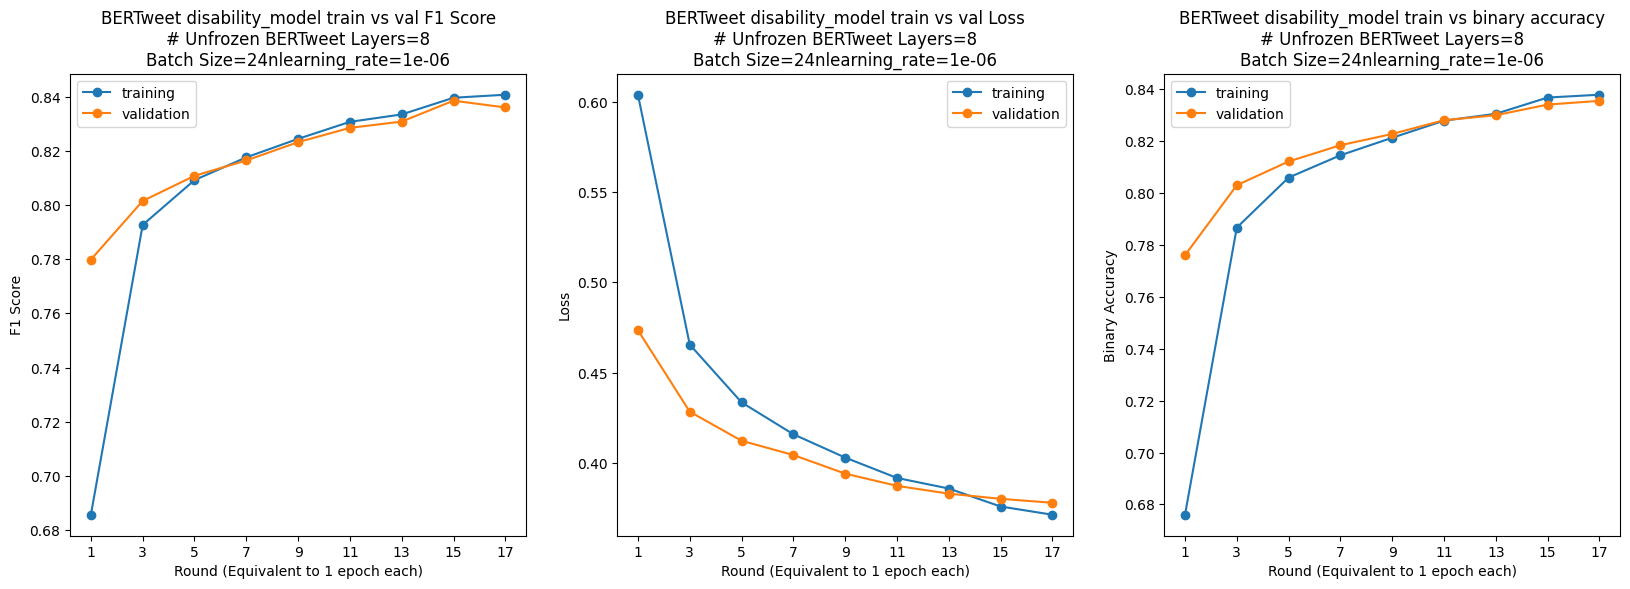

In [49]:
# DISABILITY MDOEL

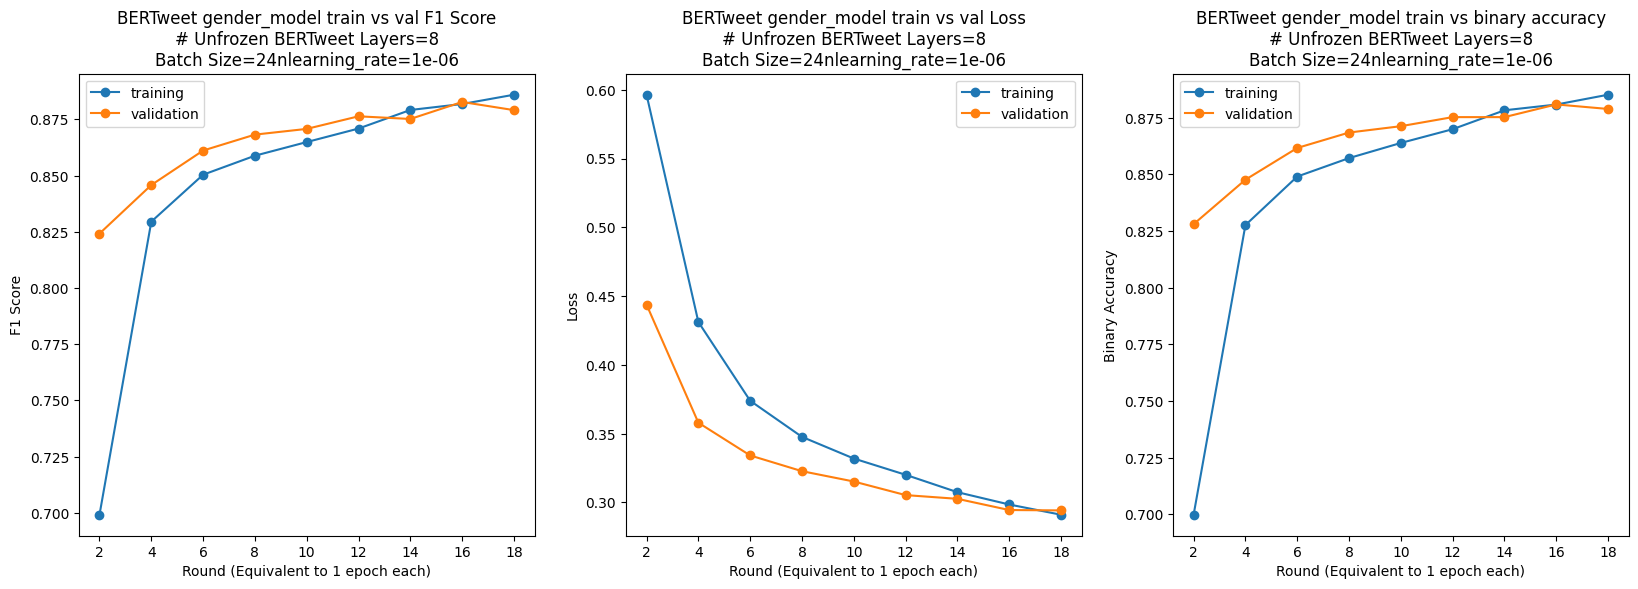

In [51]:
# GENDER MODEL

In [ ]:
# DISABILITY MODEL

In [ ]:
# GENDER MODEL